<a href="https://colab.research.google.com/github/kameshDiviyanjana/DL-9/blob/main/GAN_MNIST_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization**: The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape**: The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [2]:
# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Build the Generator Model

### **Dense Layers:** The generator takes a random noise vector of size 100 as input and generates a 28x28 image. The first layer transforms the noise into a larger representation.

### **Activation Functions:** ReLU (Rectified Linear Unit) is used for the hidden layer, and sigmoid is used for the output layer to ensure pixel values are in the [0, 1] range.

In [3]:
# # Generator model
# def build_generator():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=100))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
#     model.add(layers.Reshape((28, 28, 1)))
#     return model

# generator = build_generator()
# generator.summary()# Compile GAN with latent dimension
# Generator model with updated latent space size
def build_generator(latent_dim=100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model



# Build the Discriminator Model

### **Flatten Layer:** The discriminator processes images by flattening them into a 1D vector before feeding them into fully connected layers.

### **Output Layer:** The output is a single value between 0 and 1, representing the probability that the input image is real.

In [4]:
# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Models & Train the Model

### **Loss Function:** Binary cross-entropy is used because it is a binary classification problem (real vs. fake).

### **Optimizer:** Adam optimizer is chosen for its efficiency in training deep learning models.

### **Epochs:** The GAN is trained for a set number of epochs, with each epoch consisting of generating images and training the models.

### **Noise Generation:** Random noise is generated for the generator to create fake images.

In [5]:
# # Compile GAN
# def build_gan(generator, discriminator):
#     discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
#     discriminator.trainable = False
#     gan_input = layers.Input(shape=(100,))
#     generated_img = generator(gan_input)
#     gan_output = discriminator(generated_img)
#     gan = tf.keras.Model(gan_input, gan_output)
#     gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
#     return gan

# # Build models
# generator = build_generator()
# discriminator = build_discriminator()
# gan = build_gan(generator, discriminator)

# # Training function
# def train(epochs, batch_size=128, save_interval=200):
#     real = np.ones((batch_size, 1))
#     fake = np.zeros((batch_size, 1))

#     for epoch in range(epochs):
#         idx = np.random.randint(0, X_train.shape[0], batch_size)
#         real_imgs = X_train[idx]

#         noise = np.random.normal(0, 1, (batch_size, 100))
#         gen_imgs = generator.predict(noise)

#         d_loss_real = discriminator.train_on_batch(real_imgs, real)
#         d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         g_loss = gan.train_on_batch(noise, real)

#         if epoch % save_interval == 0:
#             print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
#             save_imgs(epoch)
# Compile GAN with latent dimension
def build_gan(generator, discriminator, latent_dim):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')
    return gan
# Training function with updated latent dimension
def train(epochs, batch_size=128, latent_dim=100, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))  # Use updated latent_dim
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(epoch, latent_dim)


# Image Generation and Visualization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.5406278371810913, acc.: 79.6875%] [G loss: [array(0.58814347, dtype=float32), array(0.58814347, dtype=float32), array(0.71875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


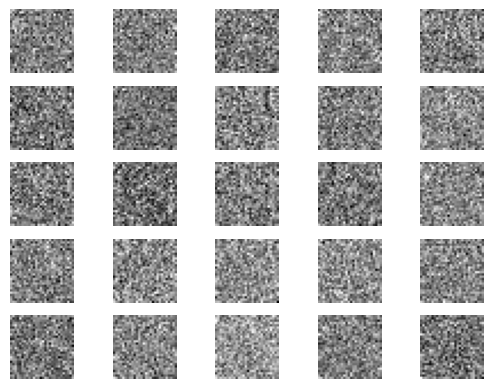

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━

In [6]:
# # Function to save generated images
# def save_imgs(epoch):
#     noise = np.random.normal(0, 1, (25, 100))
#     gen_imgs = generator.predict(noise)
#     gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
#     fig, axs = plt.subplots(5, 5)
#     cnt = 0
#     for i in range(5):
#         for j in range(5):
#             axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
#             axs[i, j].axis('off')
#             cnt += 1
#     plt.show()

# # Train the GAN
# train(epochs=1000, batch_size=64, save_interval=1000)
# Function to save generated images
def save_imgs(epoch, latent_dim):
    noise = np.random.normal(0, 1, (25, latent_dim))  # Use updated latent_dim
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
# Build models with a latent dimension of 50
latent_dim = 50
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator, latent_dim)

# Train the GAN
train(epochs=1000, batch_size=64, latent_dim=latent_dim, save_interval=1000)


# Question 01

## **Modify the latent space size (e.g., change the noise vector size from 100 to 50 or 200) and observe how this change affects the quality and variety of generated images.**

---

# Question 02

## **Train the GAN for 10,000 epochs. Save and visualize the generated images at every 1000 epochs, then create a GIF or a slideshow to show how the quality of the generated images evolves over time.**

---

# Question 03

## **Change the optimizer from Adam to RMSprop or SGD for both the generator and discriminator, and observe the impact on training performance and image quality.**

---

# Question 04

## **Experiment with different values of the batch_size. What impact does it have on training?**





